### ISC CamCan Suspense

The goal of this notebook is to perform a supplementary analysis of brain-state patterns (point-patterns, or spatial ISC)

### setting up modules

In [1]:
import os, sys, scipy, warnings
warnings.filterwarnings("ignore")

import numpy as np
import nibabel as nib
import seaborn as sns
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

from camcan_utils import *

### set up files

In [2]:
suspense_file         = '../../data/avg_suspense.npy'
dict_file             = '../../data/timeseries_dictionary.npy'
dyn_isc_file          = '../../data/dyn_isc_dict.npy'
shen_dictionary_file  = '../../data/shen_dictionary.npy'
shen_atlas_filename   = '../../data/shen_2mm_268_parcellation.nii'
sample_file           = '../../data/func.nii'

### load data 

In [3]:
# read in the time series data 
read_dictionary = np.load(dict_file, allow_pickle = True).item()
subjs           = list(read_dictionary.keys())
n_subjs         = len(subjs)
n_tr, n_regions = read_dictionary[subjs[0]]['funcdata'].shape

#re-create ts_data
ts_data = np.zeros((n_tr, n_regions, n_subjs))
for curr_sub in range(n_subjs):
    curr_sub_name           = subjs[curr_sub]
    ts_data[:,:, curr_sub]  = read_dictionary[curr_sub_name]['funcdata']

### compute pattern-based results

an alternative to isc, which measures the temporal reliability of a neural process, is to computer a pattern-isc.
Thus, instead of computing correlations over time, we compute them across space. In this case, we measure the similarity of the brain-state at a given moment in time, i.e. whether different brains are 'standing in a similar posture' (such as activated ACC, de-activated visual cortex, medium-level amygdala). The advantage of this measure is that we can resolve it in time (get one value per TR), but we lose all spatial information (get only one value for the entire brain). Of note variants of this analysis could be done via searchlight analysis.

In [4]:
''' #precomputed already - doesn't take long to run 
ts_vox_time_data    = np.swapaxes(ts_data[:,:,:], 0,1)  
pattern_isc_result_all = camcan_isc(ts_vox_time_data, summary_statistic=np.mean, verbose = False)

ts_vox_time_data    = np.swapaxes(ts_data[:,:,:248], 0,1)  ### change to e.g. 50 or so to speed up
pattern_isc_result1 = camcan_isc(ts_vox_time_data, summary_statistic=np.mean, verbose = False)

ts_vox_time_data    = np.swapaxes(ts_data[:,:,248:], 0,1)
pattern_isc_result2 = camcan_isc(ts_vox_time_data, summary_statistic=np.mean, verbose = False)

pattern_isc_result_all_z = np.squeeze(scipy.stats.zscore(pattern_isc_result_all.T))
pattern_isc_result1_z    = np.squeeze(scipy.stats.zscore(pattern_isc_result1.T))
pattern_isc_result2_z    = np.squeeze(scipy.stats.zscore(pattern_isc_result2.T))

np.save('../data/pattern_isc_result_all_z.npy', pattern_isc_result_all_z) #'''

pattern_isc_result_all_z = np.load('../../data/pattern_isc_result_all_z.npy')

### plot pattern based ISC vs. reported suspense (FigureS1)

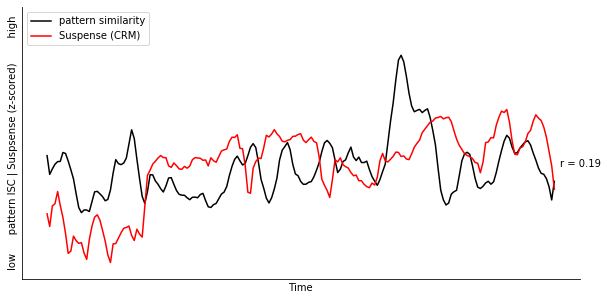

In [5]:
suspense = np.load(suspense_file)

f = plt.figure(figsize=(10,5))
rolling_pattern_isc_result_z_all = pd.DataFrame(pattern_isc_result_all_z).rolling(window = 5, center = False, win_type = 'boxcar', min_periods = 0).mean()[0].values
#rolling_pattern_isc_result1_z = pd.DataFrame(pattern_isc_result1_z).rolling(window = 5, center = False, win_type = 'boxcar', min_periods = 0).mean()[0].values
#rolling_pattern_isc_result2_z = pd.DataFrame(pattern_isc_result2_z).rolling(window = 5, center = False, win_type = 'boxcar', min_periods = 0).mean()[0].values

plt.plot(rolling_pattern_isc_result_z_all, color = 'black', label = 'pattern similarity' )
#plt.plot(rolling_pattern_isc_result1_z, color = 'gray');
#plt.plot(rolling_pattern_isc_result2_z, color = 'gray');

plt.plot(scipy.stats.zscore(suspense),   color = 'red',   label = 'Suspense (CRM)' );

alignment = np.corrcoef(
                 rolling_pattern_isc_result_z_all, #pattern_isc_result_all_z
                 scipy.stats.zscore(suspense) )[0,1]

text = ('r = ' + str(np.round(alignment, 2)) )

plt.annotate(text, xy=(194, 0))

plt.legend(loc = 2)
plt.ylim(-3, 4.3)
plt.xlabel('Time')
plt.ylabel('low      pattern ISC | Suspsense (z-scored)        high')
plt.xticks([]);
plt.yticks([]);
sns.despine()

sns.despine()

There is some moderate relationship to suspense, but overall the whole-brain pattern does not seem to track with suspense so much. Also, if stability is assessed via subgroup analyses, we see results are super accurate.

We will next see that the pattern-based ISC (which is assessed across the entire brain, quantifying a configural state), and the time-resolved ISC (process-based) are quite similar.

### plot pattern based ISC vs. dynamic ISC (FigureS2)

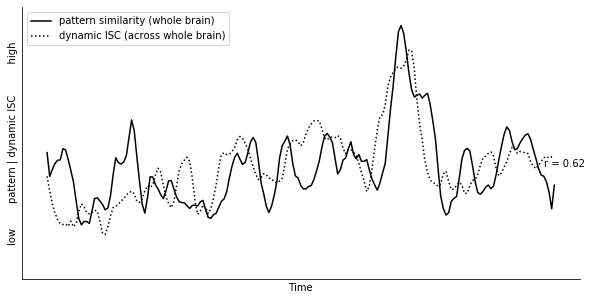

In [7]:
# load the dynamic isc results (precomputed and stored in notebook03 to save time)
dyn_isc_dict = np.load(dyn_isc_file, allow_pickle = True).item() 
dyn_isc_result_all = dyn_isc_dict['dyn_isc_result_all']
dyn_mean = np.nanmean(dyn_isc_result_all, axis = 1)

f = plt.figure(figsize=(10,5))


plt.plot(scipy.stats.zscore(rolling_pattern_isc_result_z_all), color = 'black', label = 'pattern similarity (whole brain)' )
plt.plot(scipy.stats.zscore(dyn_mean), color = 'black', linestyle = ':', label = 'dynamic ISC (across whole brain)');

alignment = np.corrcoef(
                 rolling_pattern_isc_result_z_all, 
                 dyn_mean)[0,1]
text = ('r = ' + str(np.round(alignment, 2)) )
plt.annotate(text, xy=(188, 0))

plt.legend(loc = 2)
plt.ylim(-3, 4.3)
plt.xlabel('Time')
plt.ylabel('low        pattern | dynamic ISC          high')
plt.xticks([]);
plt.yticks([]);
sns.despine()

It is interesting (and confirming) to see that the dynamic ISC (temporal ISC per region, then averaged across the regions) and the rolling-mean of the pattern ISC (pattern-correlations per TR, then smoothed out over TRs.) are highly correlated. Future work is needed to zoom in on this. Specifically, it is also very promising to resolve the pattern analyses by region, as e.g. done in Chen et al., (2016), and test reoccurrence of states (as in Baldassano et al.., 2017).